# Visualise cross-attention and self-attention maps

In this notebook we visualise both self-attention and cross-attention maps and observe how they change as we modify the input `context`.

In [ ]:
from typing import Dict

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from diffusion_models.stable_diffusion import StableDiffusion
from utils import process_image, augmenter

from visualisation_utils import plot_attention_location, animate_locations
from my_utils import dict_to_disk, dict_from_disk

In [ ]:
print(f"GPUs available: ", tf.config.experimental.list_physical_devices('GPU'))
device = tf.test.gpu_device_name()
print(tf.test.gpu_device_name())

# Initialize SD Model

In [ ]:
# Inialize Stable Diffusion Model on GPU:0
with tf.device(device):
    image_encoder = ImageEncoder()
    vae = tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-1].output,
    )
    model = StableDiffusion(img_width=512, img_height=512)

# Get latents for input image

In [4]:
image_path = "./images/polar_bear.jpg"

with tf.device(device):
    input_image = process_image(image_path)
    input_augmented = augmenter(input_image)
    latent = vae(tf.expand_dims(input_augmented, axis=0), training=False)

### Show the image

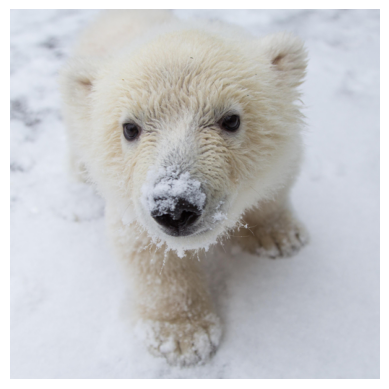

In [5]:
input_image = tf.cast(input_image, tf.int32)
plt.imshow(input_image)
plt.axis('off');

# Run inference on input image

In [6]:
# Define context shape and generate random context variation
context_shape = (1, 77, 768)
# context = None
context = tf.random.normal(context_shape)
# context = tf.zeros((1, 77, 768))
# context = tf.ones((1, 77, 768))

In [7]:
# Dictionary of structure { timestep : { resolution : self-attention map } }
self_attn_dict:  Dict[int, Dict[int, np.ndarray]] = { }
cross_attn_dict: Dict[int, Dict[int, np.ndarray]] = { }

In [8]:
num_timesteps = 10

for timestep in tqdm(np.arange(0, 1000, 1000 // num_timesteps)):
    with tf.device(device):
        (
            self_attn_64,
            self_attn_32,
            self_attn_16,
            self_attn_8,
            cross_attn_64,
            cross_attn_32,
            cross_attn_16,
            cross_attn_8,
        ) = model.generate_image(encoded_text=context, latent=latent, timestep=timestep)

        # Average attention heads and store attention maps for current time step
        self_attn_dict[timestep] = {
            8:  self_attn_8.mean(axis=(0, 1)),
            16: self_attn_16.mean(axis=(0, 1)),
            32: self_attn_32.mean(axis=(0, 1)),
            64: self_attn_64.mean(axis=(0, 1)),
        }

        cross_attn_dict[timestep] = {
            8:  cross_attn_8.mean(axis=(0, 1)),
            16: cross_attn_16.mean(axis=(0, 1)),
            32: cross_attn_32.mean(axis=(0, 1)),
            64: cross_attn_64.mean(axis=(0, 1)),
        }

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


In [9]:
# Save self-attention maps to disk
# dict_to_disk(
#     self_attn_dict=self_attn_dict,
#     filename="self_attn_maps/polar_bear"
# )

# Visualise the VAE latents

In [ ]:
# Plotting the latents
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop over each channel
for i in range(4):
    channel = latent[0, :, :, i]
    axs[i].imshow(channel, cmap="gray")
    axs[i].set_title(f"Channel {i+1}")
    axs[i].axis("off")  # Hide axis

fig.suptitle("Latents")
plt.show()

# Show the self-attention maps

In [ ]:
# Change this to a value between 0 and 4095
channel64_idx = 1140
t = 900

# Change `interpolate` to `False` to see raw pixel data
plot_attention_location(
    self_attn_dict[t],
    orig_channel_idx=channel64_idx,
    orig_res=64,
    interpolate=False,
    timestep=t
);

# Show the cross-attention maps

In [12]:
# Show which time steps `t` are contained in the dictionary
cross_attn_dict.keys()

dict_keys([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

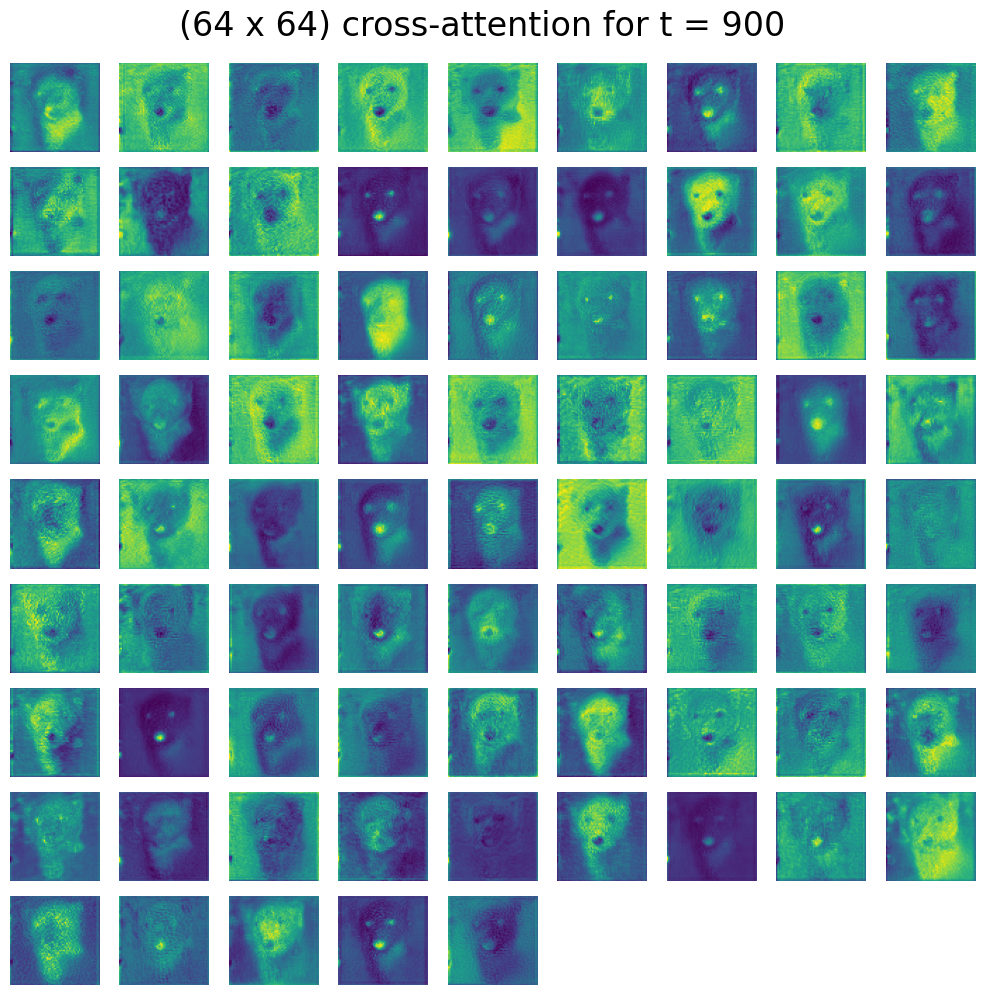

In [13]:
res = 64
t = 900

# for t in tqdm(cross_attn_dict.keys()):
cross_attn = cross_attn_dict[t][res].reshape(res, res, 77)

fig, axs = plt.subplots(9, 9, figsize=(10, 10))
axs = axs.flatten()

for idx, ax in enumerate(axs):
    if idx < 77:
        ax.imshow(cross_attn[:, :, idx])
    ax.axis('off')

fig.suptitle(f"({res} x {res}) cross-attention for t = {t} {'(unconditional)' if context is None else ''} ", fontsize=24, y=0.99)
fig.tight_layout()

# Save figure to disk as PNG
# fig.savefig(
#     f"bear_cross_res64_t{t}.png",
#     dpi=300,
#     bbox_inches="tight",
#     pad_inches=0.1,
# );